In [1]:
# Jupyter 魔法函数，在当前页面输出图像
%matplotlib inline

In [2]:
# 数据处理及导入导出
import pandas as pd

# 数据可视化基础库
import matplotlib.pyplot as plt
# 更好的可视化效果
import seaborn as sns
sns.set_style("whitegrid") #设置 seaborn 主题

# 词云
from wordcloud import WordCloud  
from imageio import imread

# 去除停用词，并将字符串转换成列表
import string
from nltk.corpus import stopwords 
stop = stopwords.words('english') #导入英文停用词

In [3]:
# 从 txt 文件中导入数据
SW_IV = pd.read_table('data/SW_EpisodeIV.txt', delim_whitespace=True, header=0, escapechar='\\')
SW_V = pd.read_table('data/SW_EpisodeV.txt', delim_whitespace=True, header=0, escapechar='\\')
SW_VI = pd.read_table('data/SW_EpisodeVI.txt', delim_whitespace=True, header=0, escapechar='\\')

In [4]:
def prep_text(series):
    '''
        去除停用词，并将字符串转换成列表
    '''
    return series.str.replace('\'', ' ').apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]).lower().translate(str.maketrans("", "", string.punctuation)).split())

In [5]:
SW_IV['clean_text'] = prep_text(SW_IV['dialogue'])
SW_V['clean_text'] = prep_text(SW_V['dialogue'])
SW_VI['clean_text'] = prep_text(SW_VI['dialogue'])

In [6]:
SW_IV.head()

,character,dialogue,clean_text
1,THREEPIO,Did you hear that? They've shut down the main...,"[did, hear, that, they, shut, main, reactor, w..."
2,THREEPIO,We're doomed!,"[we, doomed]"
3,THREEPIO,There'll be no escape for the Princess this time.,"[there, escape, princess, time]"
4,THREEPIO,What's that?,"[what, that]"
5,THREEPIO,I should have known better than to trust the l...,"[i, known, better, trust, logic, halfsized, th..."


In [7]:
SW = pd.concat([SW_IV, SW_V, SW_VI], ignore_index=True)

In [8]:
SW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2523 entries, 0 to 2522
Data columns (total 3 columns):
character     2523 non-null object
dialogue      2523 non-null object
clean_text    2523 non-null object
dtypes: object(3)
memory usage: 59.2+ KB


In [9]:
SW.groupby('character').size().sort_values(ascending=False)

character
LUKE                      494
HAN                       459
THREEPIO                  301
LEIA                      227
VADER                     140
BEN                       115
LANDO                     101
YODA                       49
EMPEROR                    44
RED LEADER                 38
BIGGS                      34
WEDGE                      33
PIETT                      31
TARKIN                     28
JABBA                      26
OWEN                       25
CREATURE                   22
TROOPER                    19
GOLD LEADER                14
ACKBAR                     14
RIEEKAN                    13
OFFICER                    13
COMMANDER                  10
CONTROLLER                  8
INTERCOM VOICE              8
RED TEN                     8
JERJERROD                   7
VEERS                       7
GOLD FIVE                   7
DECK OFFICER                7
                         ... 
ASTRO-OFFICER               1
ASSISTANT OFFICER           1


In [10]:
def character_group(name: str) -> str:
    '''
        将次要角色归类
    '''
    rebel = ('BASE VOICE', 'CONTROL OFFICER', 'MAN', 'PORKINS', 'REBEL OFFICER', 'RED ELEVEN',
             'RED TEN', 'RED SEVEN', 'RED NINE', 'RED LEADER', 'BIGGS', 'GOLD LEADER',
             'WEDGE', 'GOLD FIVE', 'REBEL', 'DODONNA', 'CHIEF', 'TECHNICIAN', 'WILLARD',
             'GOLD TWO', 'MASSASSI INTERCOM VOICE')
    imperial = ('CAPTAIN', 'CHIEF PILOT', 'TROOPER', 'OFFICER', 'DEATH STAR INTERCOM VOICE',
                'FIRST TROOPER', 'SECOND TROOPER', 'FIRST OFFICER', 'OFFICER CASS', 
                'INTERCOM VOICE', 'MOTTI', 'TAGGE', 'TROOPER VOICE', 'ASTRO-OFFICER',
                'VOICE OVER DEATH STAR INTERCOM', 'SECOND OFFICER', 'GANTRY OFFICER', 
                'WINGMAN', 'IMPERIAL OFFICER', 'COMMANDER', 'VOICE')
    neutral = ('WOMAN', 'BERU', 'CREATURE', 'DEAK', 'OWEN', 'BARTENDER', 'CAMIE', 
               'AUNT BERU', 'GREEDO', 'NEUTRAL', 'HUMAN', 'FIXER')

    if name in rebel:
        return 'Rebels'
    elif name in imperial:
        return 'Imperials'
    elif name in neutral:
        return 'Neutrals'
    else:
        return name

group_character
LUKE         254
HAN          153
Rebels       139
THREEPIO     119
BEN           82
Imperials     79
LEIA          57
Neutrals      52
VADER         41
TARKIN        28
JABBA          6
dtype: int64


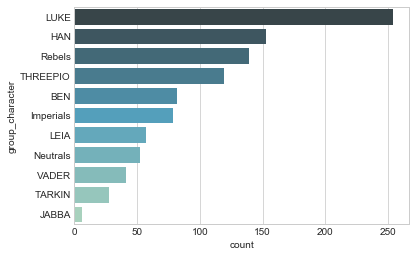

In [11]:
SW_IV['group_character'] = SW_IV['character'].apply(character_group)
    
print(SW_IV.groupby('group_character').size().sort_values(ascending=False))
    
sns.countplot(y="group_character", data=SW_IV, 
            palette="GnBu_d", 
            order = SW_IV['group_character'].value_counts().index);

In [12]:
def character_count(df):
    '''
        展示台词数前 20 的角色
    '''
    print(df.groupby('character').size().sort_values(ascending=False)[0:20])
    
    top20 = list(df.groupby('character').size().sort_values(ascending=False)[0:20].index)
    
    df_top20 = df[df['character'].isin(top20)]
    
    sns.countplot(y="character", 
                data=df_top20,
                palette="GnBu_d", 
                order = df_top20['character'].value_counts().index);

character
LUKE              254
HAN               153
THREEPIO          119
BEN                82
LEIA               57
VADER              41
RED LEADER         37
BIGGS              34
TARKIN             28
OWEN               25
TROOPER            19
GOLD LEADER        14
WEDGE              14
OFFICER            11
RED TEN             8
GOLD FIVE           7
INTERCOM VOICE      6
GREEDO              6
JABBA               6
FIRST TROOPER       6
dtype: int64


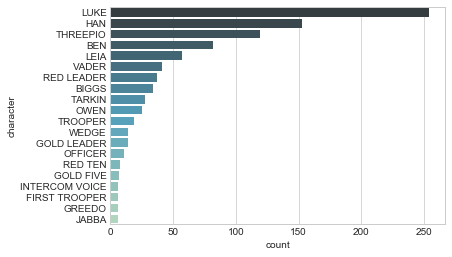

In [13]:
character_count(SW_IV)

In [14]:
def SWCloud(df, cloud_mask, vol=''):
    '''
        生成词云，并导出为 jpg 图片
    '''
    text = []

    for line in df['clean_text']:
        text.extend(line)
    
    join_text = " ".join(text)
    
    mask = imread(cloud_mask)
    
    cloud = WordCloud(
        background_color = 'white',
        mask = mask,
        max_words = 1024,
        max_font_size = 100
    )
    
    word_cloud = cloud.generate(join_text)
    word_cloud.to_file('output\SW_' + vol + '_Cloud.jpg')
    
    plt.figure(figsize=(8,8))
    plt.imshow(word_cloud) 
    plt.axis('off');

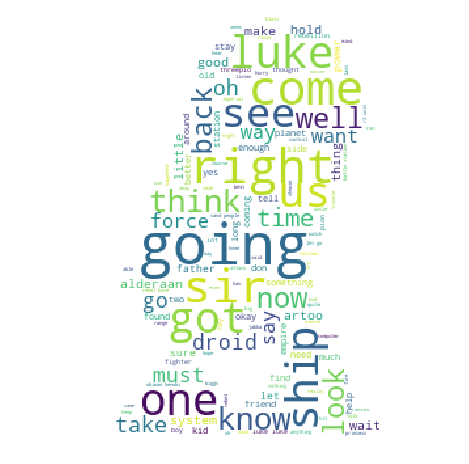

In [15]:
SWCloud(SW_IV, 'img/r2d2.png', 'IV')

character
HAN             182
LUKE            128
LEIA            114
THREEPIO         92
LANDO            61
VADER            56
YODA             36
PIETT            23
CREATURE         21
BEN              15
RIEEKAN          13
WEDGE             8
DECK OFFICER      7
VEERS             7
ZEV               6
EMPEROR           5
OZZEL             5
NEEDA             5
JANSON            4
DACK              4
dtype: int64


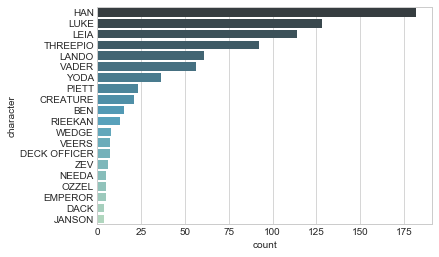

In [16]:
character_count(SW_V)

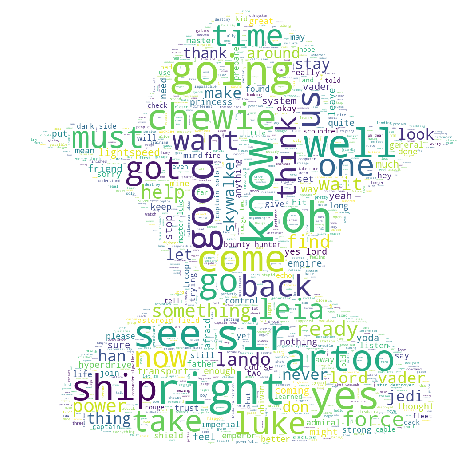

In [17]:
SWCloud(SW_V, 'img/yoda.png', 'V')

character
HAN             124
LUKE            112
THREEPIO         90
LEIA             56
VADER            43
LANDO            40
EMPEROR          39
JABBA            20
BEN              18
ACKBAR           14
YODA             13
WEDGE            11
PIETT             8
BOUSHH            7
COMMANDER         7
JERJERROD         7
STORMTROOPER      6
BIB               6
NINEDENINE        6
CONTROLLER        5
dtype: int64


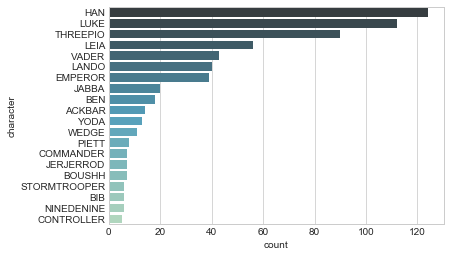

In [18]:
character_count(SW_VI)

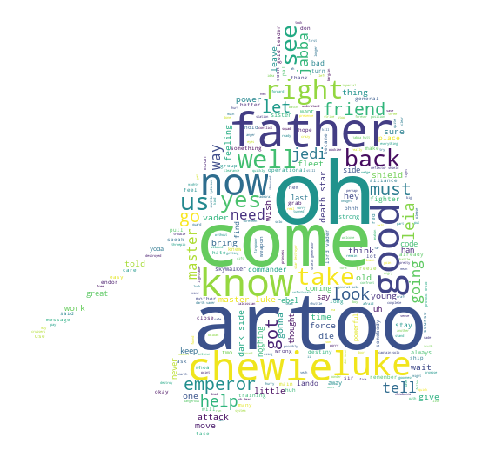

In [19]:
SWCloud(SW_VI, 'img/vader.jpg', 'VI')

character
LUKE           494
HAN            459
THREEPIO       301
LEIA           227
VADER          140
BEN            115
LANDO          101
YODA            49
EMPEROR         44
RED LEADER      38
BIGGS           34
WEDGE           33
PIETT           31
TARKIN          28
JABBA           26
OWEN            25
CREATURE        22
TROOPER         19
GOLD LEADER     14
ACKBAR          14
dtype: int64


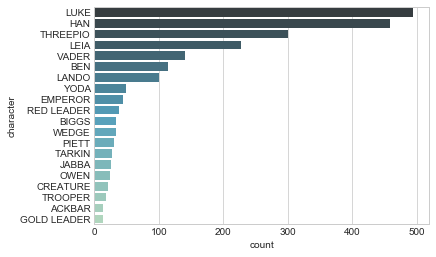

In [20]:
character_count(SW)

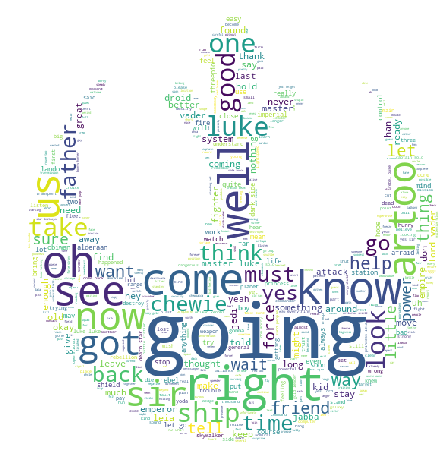

In [21]:
SWCloud(SW, 'img/rebel alliance.png')